Learnable QMC with copulas notebook. RFFs and PRFs implemented but need to make more efficient.

In [258]:
import numpy as np
from scipy.stats.distributions import chi2
from tqdm import tqdm
from scipy.stats import ortho_group
import random
import scipy
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_probability as tfp

In [259]:
def generate_K(x):
    "function to get groundtruth kernel matrix"
    nb_datapoints = np.shape(x)[0]
    K = np.zeros((nb_datapoints,nb_datapoints))
    for i in range(nb_datapoints):
        for j in range(nb_datapoints):
            K[i,j] = np.exp( - sum((x[i] - x[j])**2) / 2)
    return K

In [260]:
#hyperparameters
d= 2     #number of dimensions
nb_datapoints = 2       #number of datapoints (= dimensionality of Gram matrix)
sigma = 0.3     #regulariser in kernel

In [261]:
tfd = tfp.distributions
chi2_dist = tfd.Chi2(d)
norm_dist = tfd.Normal(loc=0.,scale=1.)

In [262]:
# choose the respective directions of weight vectors ($\hat{\omega}$). Below is orthogonal directions and their antithetic counterparts (=2d vectors in total)
basis = np.eye(d)
basis = tf.convert_to_tensor(np.vstack((basis,-basis)), dtype=float)

nb_vecs = len(basis)

In [263]:
class Model(tf.keras.Model):
    "function that returns correlated ws. 'thetas' parameterise correlations between lengths. Note need random rotation also that is not included in here"
    def __init__(self, initial_thetas):
        #length of initial thetas should be 1/2 * nb_vecs * (nb_vecs - 1)
        super(Model, self).__init__()
        self.thetas =tf.Variable(np.asarray(initial_thetas),dtype=float)

    def call(self,input):  #currently has a dummy input
        thetas = self.thetas

        #make Cholesky decomposition of cov matrix with 1 on diagonals using the thetas
        L = np.ndarray.tolist(np.tril(np.ones((nb_vecs,nb_vecs))))

        #putting in thetas (doing it here is inefficient -- TODO change)
        counter = 0
        for i in range(nb_vecs-1):
            for j in range(i+1):
                L[i+1][j] *= tf.cos(thetas[counter])
                L[i+1][j+1:] *= tf.sin(thetas[counter])
                counter +=1
        L = tf.convert_to_tensor(L, dtype=float)


        eps = tf.random.normal([nb_vecs]) #generate random Gaussian noise
        L_prime = norm_dist.cdf(tf.linalg.matvec(L,eps))     #generate vector distributed normally with cov LL^\top then put through cdf to get uniform
        lengths = tf.sqrt(chi2_dist.quantile(L_prime))      #push through chi inverse cdf to get lengths
        ws = tf.matmul(tf.linalg.diag(lengths),basis)       #use to rescale basis vectors to get weight vectors
        return ws

In [264]:
initial_thetas = np.ones(  int( 0.5 * nb_vecs * (nb_vecs - 1))) * 0.5 * np.pi       #these initial thetas give identity covariance matrix
get_weights = Model(initial_thetas)

In [265]:
#Generate data and get groundtruth kernel

xs = tf.random.normal(shape = (nb_datapoints,d))        #nb_datapoints random x vectors of dimensionaltiy d 
xs -= np.mean(xs)       #normalise (doesn't change kernel evaluations but makes converge better)
xs *= sigma     #regularise
K_groundtruth = generate_K(xs.numpy())

In [266]:
def get_tf_copula_rffs(nb_features,xs, get_weights): 
    "function to get random fourier features with coupling specified by get_weights copula"
    for feature in range(nb_features):
        ws = get_weights(0)  #get the ws
        rotation = tf.constant(ortho_group.rvs(d), dtype = float)      #get the rotation matrix to apply to all the data
        holder = tf.matmul(ws,tf.matmul(rotation,tf.transpose(xs)))     #get projections w^Tx
        cs_holder = tf.concat([tf.cos(holder),tf.sin(holder)],axis=0)
        if feature == 0:
            rfs = cs_holder
        else:
            rfs = tf.concat((tf.reshape(rfs, [feature,2*nb_vecs,len(xs)]),tf.reshape(cs_holder, [1,2*nb_vecs,len(xs)])),axis=0)
    rfs = tf.transpose(tf.reshape(rfs, [nb_features*2*nb_vecs,len(xs)])) / np.sqrt(nb_features * nb_vecs)
    return rfs

def get_tf_copula_prfs(nb_features,xs, get_weights): 
    "function to get positive random features with coupling specified by get_weights copula"
    for feature in range(nb_features):
        ws = get_weights(0)  #get the ws
        rotation = tf.constant(ortho_group.rvs(d), dtype = float)      #get the rotation matrix to apply to all the data
        holder = tf.matmul(ws,tf.matmul(rotation,tf.transpose(xs)))        #get projections w^Tx
        cs_holder = tf.exp(holder)
        if feature == 0:
            rfs = cs_holder
        else:
            rfs = tf.concat((tf.reshape(rfs, [feature,nb_vecs,len(xs)]),tf.reshape(cs_holder, [1,nb_vecs,len(xs)])),axis=0)
    rfs = tf.transpose(tf.reshape(rfs, [nb_features*nb_vecs,len(xs)])) / np.sqrt(nb_features * nb_vecs)
    rfs = tf.linalg.matmul(tf.linalg.diag(tf.exp(-tf.reduce_sum(xs**2,axis=1))), rfs)       #prfs need an extra normalisation factor
    return rfs

In [267]:
def get_loss(nb_features, xs, K_groundtruth, nb_trials, feature_type, get_weights):
    "Loss function, takes get_weights as input and returns relative Frob norm error between true and approximated Gram matrices"
    loss = 0
    for _ in range(nb_trials):
        if feature_type == 'rff':
            rfs = get_tf_copula_rffs(nb_features, xs, get_weights)
        elif feature_type == 'prf':
            rfs = get_tf_copula_prfs(nb_features, xs, get_weights)
        else:
            raise Exception('Not a valid type of feature')
        prediction = tf.matmul(rfs,tf.transpose(rfs))       #dot product the RFs to get kernel estimate
        loss += tf.reduce_sum((tf.constant(K_groundtruth, dtype=float) - prediction)**2) / tf.reduce_sum((tf.constant(K_groundtruth, dtype=float) )**2)     #add relative Frob norm between true and approx kernel matrices to loss
    return loss / nb_trials


In [268]:
#Train the QMC copula

epochs = 100     #epochs to train for
nb_trials = 100     #number of samples to get MC estimate whose gradient we take (N_s in technical note)
nb_features = 1     #number of features (copies of W matrix) used in each kernel matrix

initial_lr = 500
lrs = np.exp(np.linspace(np.log(initial_lr),np.log(0.1),epochs))        #lr scheduler

loss_log = []

for epoch in range(epochs):
    print('epoch: %s' % (epoch+1))
    
    with tf.GradientTape() as tape:
        loss = get_loss(nb_features, xs, K_groundtruth, nb_trials, 'rff', get_weights)  #evaluate loss
        loss_log.append(loss)
    
    print('loss: %s'%(loss.numpy()))

    grad = tape.gradient(loss,get_weights.trainable_variables)      #compute gradient and backprop
    optimiser = tf.keras.optimizers.SGD(learning_rate = lrs[epoch])
    optimiser.apply_gradients(zip(grad,get_weights.trainable_variables))        #update thetas
   


epoch: 1


loss: 0.0010990282
epoch: 2
loss: 0.0016322632
epoch: 3
loss: 0.0008061904
epoch: 4
loss: 0.00061567203
epoch: 5
loss: 0.0006780032
epoch: 6
loss: 0.0005210888
epoch: 7
loss: 0.00045642443
epoch: 8
loss: 0.0007238395
epoch: 9
loss: 0.00036962694
epoch: 10
loss: 0.00052395865
epoch: 11
loss: 0.00043927252
epoch: 12
loss: 0.00046898783
epoch: 13
loss: 0.0009424964
epoch: 14
loss: 0.00057042675
epoch: 15
loss: 0.0005963895
epoch: 16
loss: 0.00035125745
epoch: 17
loss: 0.00058416487
epoch: 18
loss: 0.00027133583
epoch: 19
loss: 0.0004879742
epoch: 20
loss: 0.0006246453
epoch: 21
loss: 0.00068836735
epoch: 22
loss: 0.00029649405
epoch: 23
loss: 0.0005177209
epoch: 24
loss: 0.00038831457
epoch: 25
loss: 0.00031021974
epoch: 26
loss: 0.00034686993
epoch: 27
loss: 0.0006998285
epoch: 28
loss: 0.00036572656
epoch: 29
loss: 0.00032653517
epoch: 30
loss: 0.00055131735
epoch: 31
loss: 0.00028837041
epoch: 32
loss: 0.00041505578
epoch: 33
loss: 0.00034997743
epoch: 34
loss: 0.0003114811
epoch: 35
l

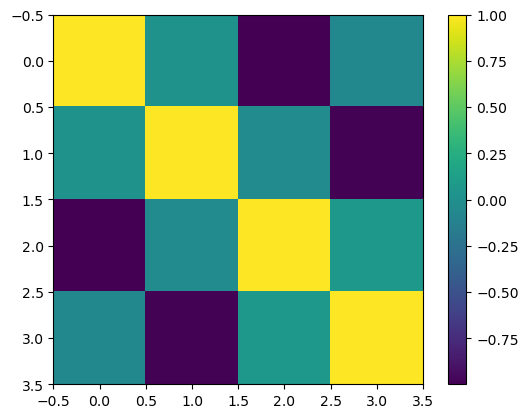

In [269]:
#To visualise what the covariance matrix looks like after training

thetas= get_weights.trainable_variables[0].numpy()
L = np.ndarray.tolist(np.tril(np.ones((nb_vecs,nb_vecs))))
counter = 0
for i in range(nb_vecs-1):
    for j in range(i+1):
        L[i+1][j] *= tf.cos(thetas[counter])
        L[i+1][j+1:] *= tf.sin(thetas[counter])
        counter +=1
L = tf.convert_to_tensor(L, dtype=float).numpy()
M = L @ L.T
plt.imshow(M)
plt.colorbar()

Text(0.5, 0, 'Epochs')

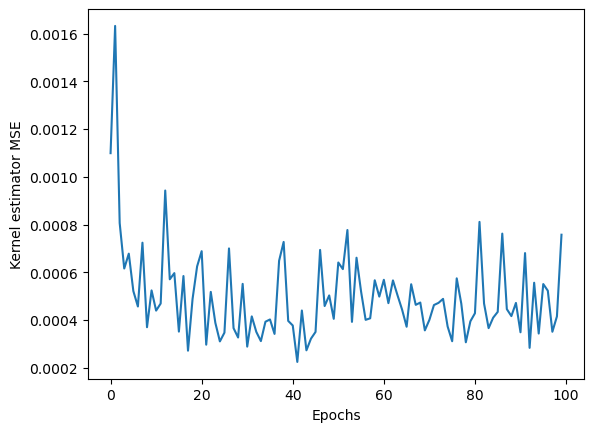

In [270]:
#Plot the training curve

plt.plot(tf.convert_to_tensor(loss_log).numpy())
plt.ylabel('Kernel estimator MSE')
plt.xlabel('Epochs')


In [271]:
#To evaluate approximation error with some particular theta

if False:

    thetas = thetas_save
    #thetas = 0.5 * np.ones(28)

    tests=100
    log = []

    for _ in tqdm(range(tests)):
        get_weights = Model(thetas)
        log.append(get_rff_loss(nb_features, xs, K_groundtruth, 10, get_weights))
    
    print(np.mean(log))
    print(np.std(log)/np.sqrt(tests))
